In [378]:
first_run = False

In [379]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from langdetect import detect
import matplotlib.dates as md

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read in the data

In [380]:
fs = glob.glob('data/EU_Commission/*')

In [381]:
def _read_tweets(fs, metrics, fields):
    processed_tws = []
    for f in fs:
        tws = json.load(open(f))['data']
        for i in range(len(tws)):
            item = {k: tws[i][k] for k in fields}
            item.update({k: tws[i]['public_metrics'][k] for k in metrics})
            item.update({'created_at': tws[i]['created_at'][:10]})
            tws[i] = item
        processed_tws += tws
        df = pd.DataFrame(processed_tws)
        df['created_at'] = pd.to_datetime(df['created_at'], 
                                          infer_datetime_format=True)
    return df

In [382]:
fields = ['text', 'lang', 'id']
metrics = [f'{m}_count' 
           for m in ['like','quote','reply','retweet']]
df = _read_tweets(fs, metrics, fields)

### Tweet volume

In [339]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (50,5), 'W': (50,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}

def plot_volume(language='en', freqs='D', plot_smooth_only=False, roll_window=7):
    top_dict = {}
    for freq in [freqs]:
        fig, ax = plt.subplots(figsize=figsizes[freq])
        grouper = pd.Grouper(key='created_at', axis=0, freq=freq)
        if df['created_at'].dtype != 'datetime64':
            df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)
        if language=='all':
            grouped = df.groupby(grouper).count().reset_index()      
        elif language=='en':
            grouped = df.groupby(grouper).count().reset_index()
        else:
            new_df = df.copy()
            new_df['is_other'] = np.where((new_df['lang']=='en') & (new_df['lang_detected']=='en'), 0, 1)
            counts = new_df.groupby(grouper).count().reset_index()[['created_at','text']].rename({'text': 'count'}, axis=1)
            by_lang = new_df.groupby([grouper,'is_other']).count().reset_index() 
            grouped = pd.merge(by_lang, counts, how='outer')
            grouped['text'] = np.where(grouped['count'] != 0, grouped['text'] / grouped['count'], 0)
            grouped = grouped[grouped['is_other']==1]
            grouped = grouped.fillna(0)
        top_dict[freq_dict[freq]] = grouped.sort_values(by='text', ascending=False).head(n=5)[['created_at', 'text']].to_records(index=False)
        grouped['smoothed'] = grouped['text'].rolling(roll_window).mean()
        # Plot 
        if not plot_smooth_only:
            sns.lineplot(data=grouped, x='created_at', y='text', 
                         alpha=.2, 
                         label='per day')
        sns.lineplot(data=grouped, x='created_at', y='smoothed', 
                     label=f'smoothed avg - {roll_window}d', 
                     color=sns.color_palette()[0])
        if language in ['all', 'en']:
            plt.ylabel(f'Tweets per {freq_dict[freq]}')
            plt.xlabel('')
            plt.title(f'Tweet volume {language.upper()}')
        else:
            plt.ylabel(f'Proportion tweets per {freq_dict[freq]}')
            plt.xlabel('')
            plt.title(f'Proportion tweets not in English')
        plt.xticks(rotation=60)
        # Make year boundaries
        for d in grouped.created_at.dt.year.unique()[1:]:
            plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
            plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'),120), color='black')
        ax.xaxis.set_major_locator(md.MonthLocator())
        ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
        plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
        if language == 'en':
            plt.savefig(f'figures/tweet_volume_EN.pdf')
        else:
            plt.savefig(f'figures/tweet_volume_others.pdf')
        plt.show()
    return top_dict

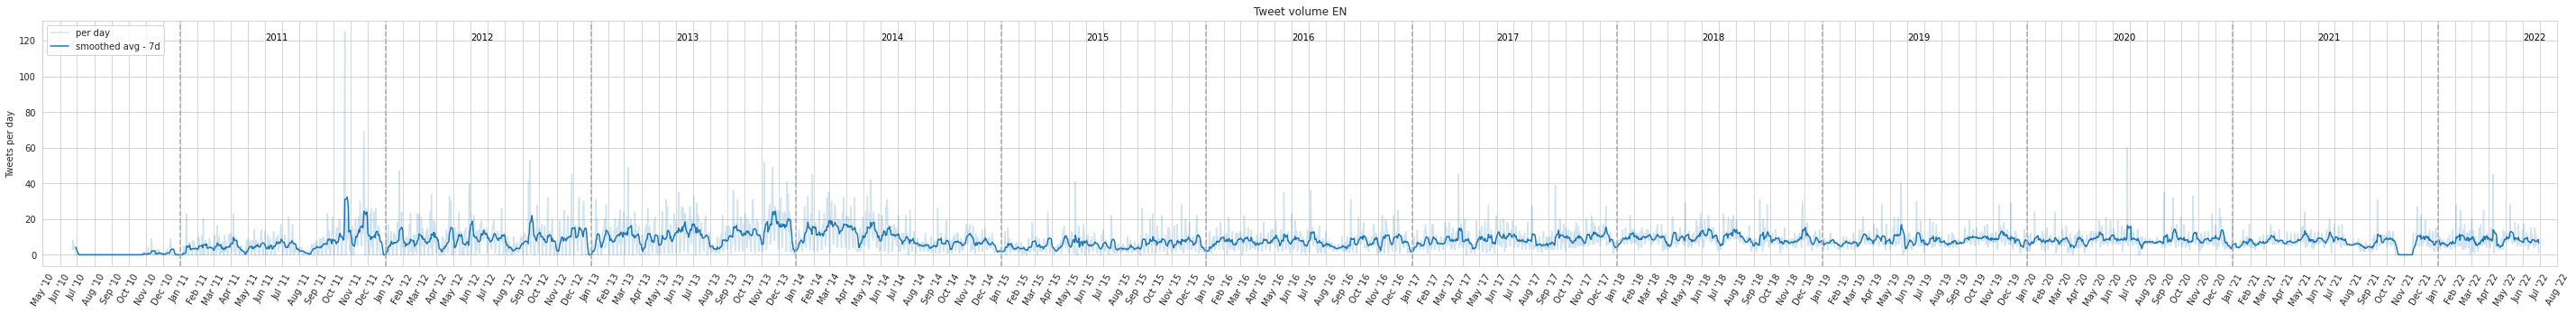

In [340]:
top_dict = plot_volume(roll_window=7)

In [341]:
#print(df[df.created_at == np.datetime64(top_dict['day'][1][0])].text.tolist())
#print(top_dict['day'][1][0])

Some of the peaks with highest volumes are related to live tweeting of #EUMFF negotiations, automated posting re: to activity on other websites (Storify), and other. 
Worth keeping in mind that tweet volume can be a major confounder with this data.

### Additional preprocessing
- flag retweets and tweets starting with mentions;
- strip links;
- not removing emojis, hashtags and mentions, for now - but could remove depending on which model we end up using;
- assign some tweet to a "pretraining" dataset

Re: this latter. Let's leave out a small dataset for pretraining of our language models. We pick a random set of tweets (if that does not show good results, we could consider balanced sampling over time).

In [361]:
def language_detection(s):
    try:
        return detect(s)
    except:
        return 'unk'

In [362]:
def _preprocessing(df):
    df['is_retweet'] = np.where(df['text'].str.startswith('RT'), 1, 0)
    df['is_mention'] = np.where(df['text'].str.startswith('@'), 1, 0)
    df['text'] = df['text'].str.replace(r'http.*', '', regex=True)
    df = df[df['text'].str.len() > 0]
    df['lang_detected'] = df['text'].apply(language_detection)
    return df

In [363]:
if first_run is True:
    
    df = _preprocessing(df)
    
    # Pretraining splits
    import random
    random.seed(42)
    train_size = 3000
    val_size = 500
    train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * (df.shape[0] - train_size - val_size)
    random.shuffle(train_test)
    df['pretraining_splits'] = train_test
    
    # Save
    df.to_json('processed/all_tweets.jsonl', lines=True, orient='records')

Breakdown of number of tweets per language

In [364]:
df = pd.read_json('processed/all_tweets.jsonl', lines=True, orient='records')
print(df.groupby('lang')['text'].count().reset_index().sort_values(by='text', ascending=False).rename({'text': 'count'}, axis=1))

   lang  count
7    en  32446
12   fr    828
5    de    207
8    es    155
29  und    122
17   it     81
24   ro     69
28   uk     47
22   pl     45
20   nl     37
23   pt     36
1    ca     33
6    el     29
4    da     28
9    et     23
11   fi     22
2    cs     21
26   sv     19
0    bg     16
15   in     12
19   lv     10
18   lt     10
25   sl     10
14   hu      9
27   tl      5
3    cy      4
13   ht      2
10   eu      2
21   no      1
16   is      1


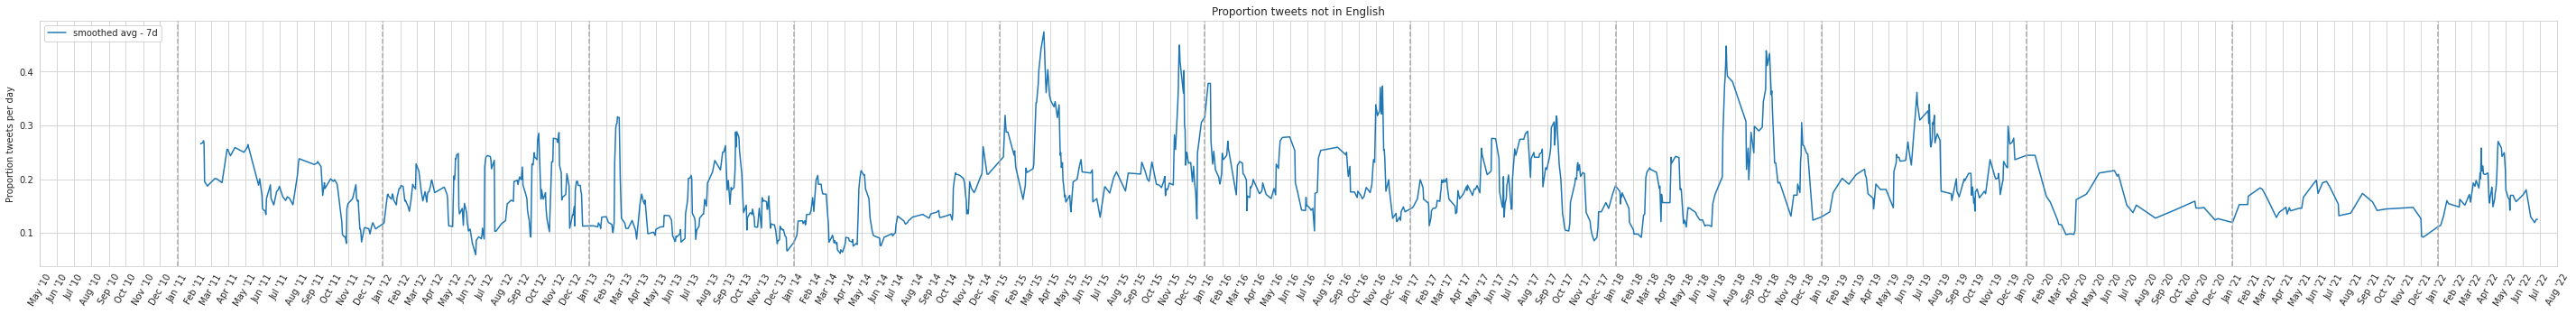

In [365]:
top_dict_other = plot_volume(language='other', freqs='D', plot_smooth_only=True, roll_window=7)

Removing tweets not in English, it's mostly translations of English tweets. We know that Twitter's automatic language detection is not great, so double-checking with langdetect and only including tweets tagged as English by both the default tagger and langdetect.

In [366]:
df = df[(df['lang']=='en') & (df['lang_detected']=='en')]

Great, now let's fine tune some language models on these tweets for better performance (see pretrain script)

### Pretraining performance analysis

In [921]:
performances = pd.read_json('logs/pretraining/performances.jsonl', lines=True, orient='records')
performances['id'] = performances['name'].str.split('_').str[0]
performances['learning_rate'] = performances['name'].str.split('_').str[1].str.split('-').str[1].astype(float)
performances['batch_size'] = performances['name'].str.split('_').str[4].str.split('-').str[1].astype(int)
performances['warmup'] = performances['name'].str.split('_').str[5].str.split('-').str[1].astype(float)
performances['chunk_size'] = performances['name'].str.split('_').str[2].str.split('-').str[1].astype(float)

Let's first visualize the impact of learning rates.

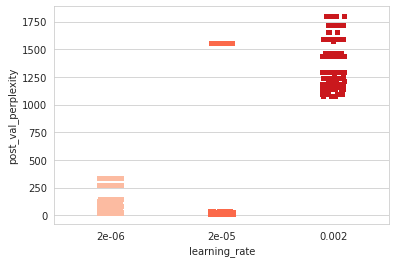

In [941]:
sns.stripplot(data=performances.sort_values(by='post_val_perplexity'), 
              x='learning_rate', y='post_val_perplexity', 
              palette='Reds', 
              marker='s')
plt.show()

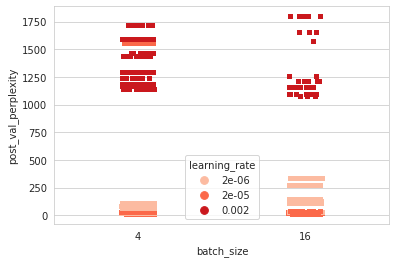

In [926]:
sns.stripplot(data=performances.sort_values(by='post_val_perplexity'), 
              x='batch_size', y='post_val_perplexity', 
              hue='learning_rate',
              marker='s', palette='Reds')
plt.show()

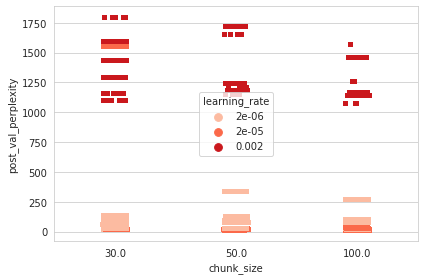

In [928]:
sns.stripplot(data=performances.sort_values(by='post_val_perplexity'), 
              x='chunk_size', y='post_val_perplexity', 
              hue='learning_rate',
              marker='s', palette='Reds')
plt.tight_layout()
plt.show()

Best learning rate seems to be univocally 2e-5, we'll go for batch_size=4 and chunk_size=100.

### Topic modeling preparation
Let's move on to modeling the topic of the tweets. We'll try to compare different modeling strategies, and both pretrained and fine-tuned models.
Then, we'll try to get an idea of what the evolution of topics has been over time. 
Let's start from comparing model metrics for multiple models, and parameter optimization configs.

#### Generate data

In [15]:
first_contextualized_run = False

In [16]:
if first_contextualized_run is True:
    topic_df = df[df['pretraining_splits']=='test'].sample(frac=1).reset_index()
    
    # Train test split
    import random
    random.seed(42)
    train_size = int(topic_df.shape[0] * .7)
    val_size = int(topic_df.shape[0] * .1)
    test_size = topic_df.shape[0] - train_size - val_size
    train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * test_size
    random.shuffle(train_test)
    
    # Pretrained
    topic_df['topic_split'] = train_test 
    topic_df.to_json('processed/pre_topic_tweets.jsonl', lines=True, orient='records')

Training through `run_topics.py`

#### Model selection

In [253]:
topic_perf = pd.read_json('logs/topic/performances.jsonl', 
                          orient='records', 
                          lines=True)

In [538]:
def _preprocess_topic_performance(d):
    for k in ['vocab', 'bow', 'esize']:
        d[k] = d['name'].str.split(f'{k}-').str[1].str.split('_').str[0].astype(int)
    map_dict = {'comp': [8, 3],
                'lr': [11, 6],
                'batch': [10, 5]}
   
    def _get_name_substr(col, idx, n):
        try:
            return col.str.split('_').str[idx].str.lstrip(fr'{n}\-')
        except:
            return np.nan
    
    def _match_finetuned_affix(col):
        return col.str.split('_').str[0].str.endswith(r'finetuned')
        
    def _make_col(n):
        return np.where(_match_finetuned_affix(d['name']), 
                        _get_name_substr(d['name'], map_dict[n][0], n),
                        _get_name_substr(d['name'], map_dict[n][1], n)).astype(float)
    d['components'] = _make_col('comp')
    d['lr_topic'] = _make_col('lr')
    d['batch_topic'] = _make_col('batch')
    d['lr_pretraining'] = np.where(_match_finetuned_affix(d['name']), 
                                   _get_name_substr(d['name'], 1, 'lr\-'),
                                   0).astype(float)
    d['unique_id'] = d['name'].str.split('_').str[0]
    for c in ['components', 'vocab', 'lr_topic', 'batch_topic']:
        d['unique_id'] = d['unique_id'] + f'_{c.split("_")[0]}-' + \
                         d[c].astype(str)
    d['unique_run'] = d['unique_id'] + '_run-' + d['run'].astype(str)    
    return d
    
    

In [255]:
topic_perf = _preprocess_topic_performance(topic_perf)

Plot performances

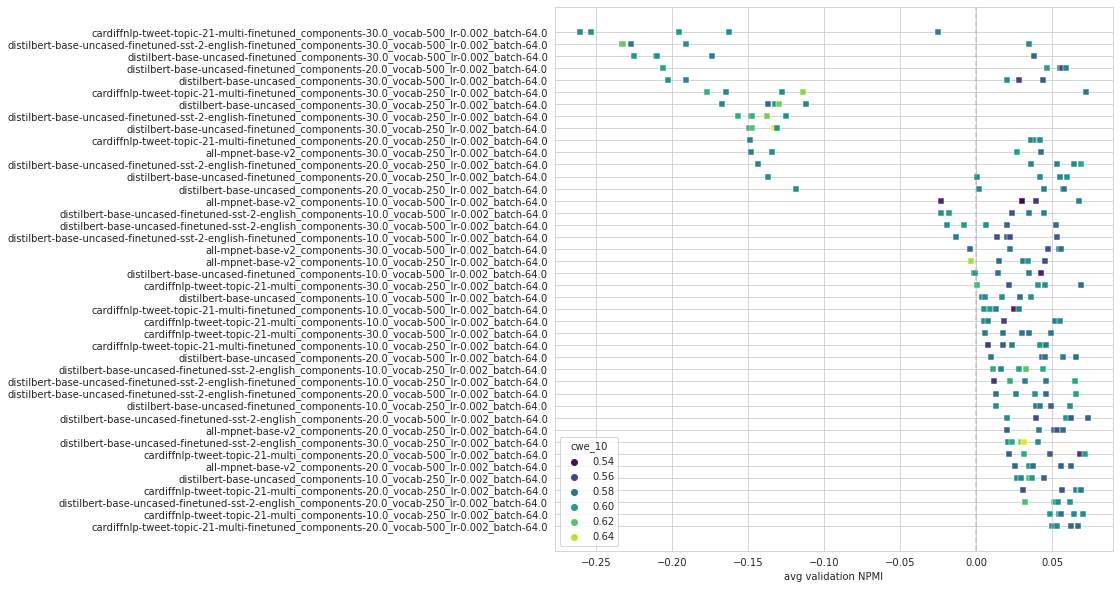

In [256]:
sns.set_style('whitegrid')
plt.subplots(figsize=(10,10))
plt.axvline(0, linestyle='--', color='darkgrey', alpha=.6)
sns.scatterplot(data=topic_perf.sort_values(by='test_npmi_10'), 
                y='unique_id', x=f'test_npmi_10', color='darkgrey',
               marker='s', hue='cwe_10', palette='viridis')
plt.xlabel('avg validation NPMI')
plt.ylabel('')
plt.show()

Save best models

In [21]:
grouped = topic_perf.groupby('unique_id').mean().reset_index().sort_values(by='val_npmi_10')
grouped = grouped.merge(topic_perf[['unique_id', 'name']].drop_duplicates())
grouped['id'] = grouped['name'].str.split('_vocab').str[0]
grouped = grouped.sort_values(by='val_npmi_10').tail(n=20)
grouped = grouped[['id', 'vocab', 'bow', 'esize', 'components', 'lr_topic', 'batch_topic']]
grouped.to_json('logs/topic/best_models.jsonl', lines=True, orient='records')

Now fitting and saving these models through `fit_topic_final.py`

### Pick final model

In [539]:
def _load_and_process_performances(fname):
    topic_perf = pd.read_json(fname, 
                              orient='records', 
                              lines=True)
    topic_perf = _preprocess_topic_performance(topic_perf)
    topic_perf = topic_perf.sort_values(by='test_npmi_10', ascending=False).reset_index(drop=True)
    topic_perf['top_npmi'] = (topic_perf.index < 5).astype(int) # 
    topic_perf['npmi_rank'] = topic_perf.index
    topic_perf = topic_perf.sort_values(by='cwe_10', ascending=False).reset_index(drop=True)
    topic_perf['top_cwe'] = (topic_perf.index < 5).astype(int)
    topic_perf['cwe_rank'] = topic_perf.index
    topic_perf = topic_perf.sort_values(by='rbo_10', ascending=False).reset_index(drop=True)
    topic_perf['top_rbo'] = (topic_perf.index < 5).astype(int)
    topic_perf['rbo_rank'] = topic_perf.index
    return topic_perf

In [524]:
topic_perf = _load_and_process_performances('logs/topic/performances_final.jsonl')

Get baseline models

In [232]:
baselines = pd.read_json('logs/baselines/performances.jsonl', 
                         orient='records', 
                         lines=True)
baselines = baselines.pivot(index='name', columns='split', values='score').reset_index().rename({'train': 'train_npmi_10',
                                                                                                   'val': 'val_npmi_10', 
                                                                                                   'test': 'test_npmi_10'}, axis=1)
baselines['unique_id'] = baselines['name']
baselines['top_npmi'] = 2
baselines = baselines.sort_values(by='test_npmi_10', ascending=False).head(n=20)
topic_perf = pd.concat([baselines, topic_perf], ignore_index=True)

<ipython-input-233-73e2614fc5cd>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()
<ipython-input-233-73e2614fc5cd>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baselines = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==2].unique_id.tolist()


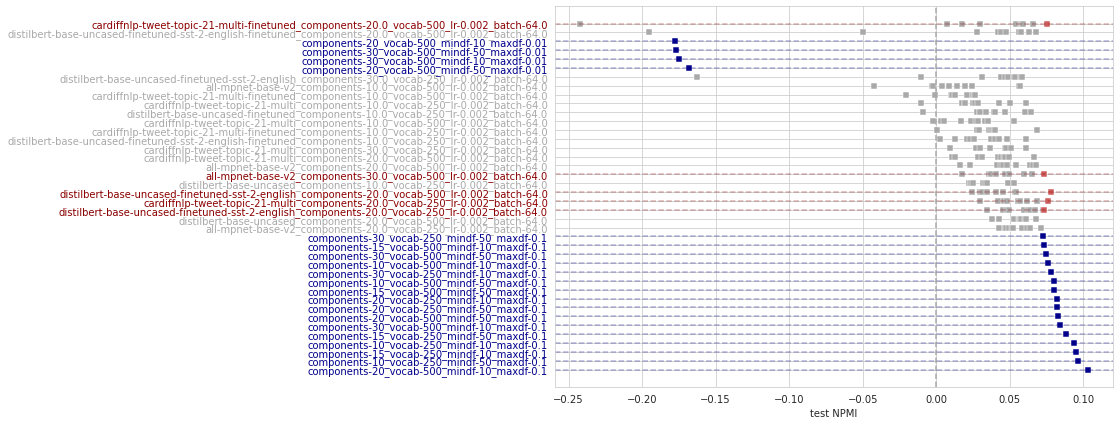

In [233]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,7))
plt.axvline(0, linestyle='--', color='darkgrey')
sns.scatterplot(data=topic_perf.sort_values(by='test_npmi_10'), 
                y='unique_id', x=f'test_npmi_10', 
                hue='top_npmi', 
                legend=False, 
                palette=['darkgrey', 'indianred', 'darkblue'],
                marker='s')
best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()
baselines = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==2].unique_id.tolist()
label_cols = []
for model_n in topic_perf.sort_values(by='test_npmi_10')["unique_id"].unique():
    if model_n in best_names:
        label_cols.append("darkred")
    elif model_n in baselines:
        label_cols.append("darkblue")
    else:
        label_cols.append("darkgrey")
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
for b in baselines:
    plt.axhline(b, color='darkblue', linestyle='--', alpha=.3)
plt.xlabel('test NPMI')
plt.ylabel('')
plt.show()

Compute extrinsic metrics for contextualized topic models

<ipython-input-234-0ddf7c32c70c>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()


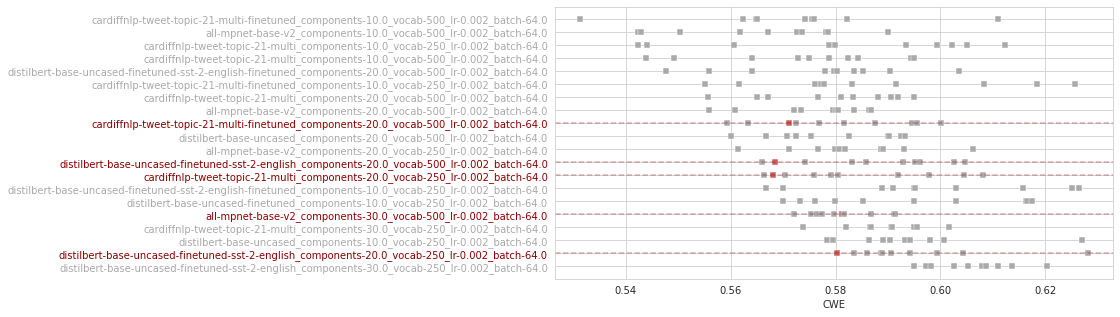

In [234]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=topic_perf.sort_values(by='cwe_10'), 
                y='unique_id', x=f'cwe_10', 
                hue='top_npmi', 
                legend=False, 
                palette=['darkgrey', 'indianred', 'darkblue'],
                marker='s')
best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()
label_cols = ["darkred" if model_n in best_names else 'darkgrey' 
              for model_n in topic_perf.sort_values(by='cwe_10')["unique_id"].unique()]
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
plt.xlabel('CWE')
plt.ylabel('')
plt.show()

<ipython-input-235-229eca814cd5>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()


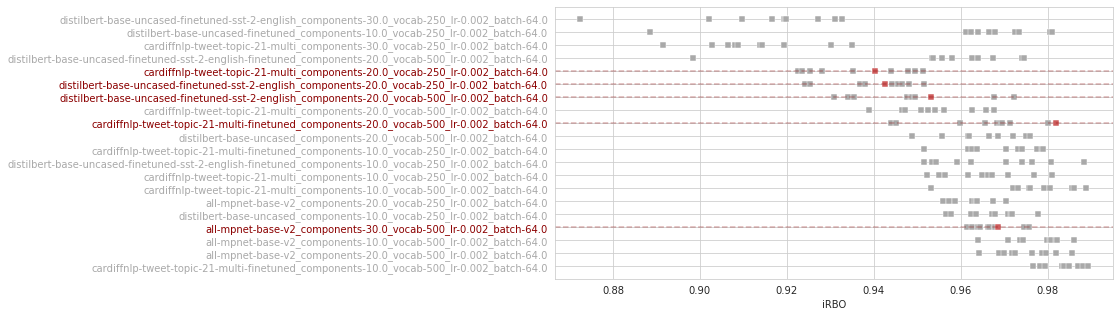

In [235]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=topic_perf.sort_values(by='rbo_10'), 
                y='unique_id', x=f'rbo_10', 
                hue='top_npmi', legend=False, 
                palette=['darkgrey', 'indianred', 'darkblue'],
                marker='s')
best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()
label_cols = ["darkred" if model_n in best_names else 'darkgrey' 
              for model_n in topic_perf.sort_values(by='rbo_10')["unique_id"].unique()]
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
plt.xlabel('iRBO')
plt.ylabel('')
plt.show()

### Analyze final model

In [240]:
top_npmi = list(zip(topic_perf.sort_values(by='test_npmi_10', ascending=False).head(n=20).name.tolist(),
                    topic_perf.sort_values(by='test_npmi_10', ascending=False).head(n=20).run.tolist()))

In [241]:
top_map = {}
for t in top_npmi:
    if np.isnan(t[1]):
        topics = json.load(open(f'logs/baselines/model_{t[0]}.json'))
        top_map[f'{t[0]}'] = topics
    else:
        topics = json.load(open(f'logs/topic/{t[0]}/topic_map_{int(t[1])}.json'))
        top_map[f'{t[0]}_{t[1]}'] = topics

In [242]:
top_npmi

[('components-20_vocab-500_mindf-10_maxdf-0.1', nan),
 ('components-10_vocab-250_mindf-50_maxdf-0.1', nan),
 ('components-15_vocab-250_mindf-10_maxdf-0.1', nan),
 ('components-10_vocab-250_mindf-10_maxdf-0.1', nan),
 ('components-15_vocab-250_mindf-50_maxdf-0.1', nan),
 ('components-30_vocab-500_mindf-10_maxdf-0.1', nan),
 ('components-20_vocab-500_mindf-50_maxdf-0.1', nan),
 ('components-20_vocab-250_mindf-50_maxdf-0.1', nan),
 ('components-20_vocab-250_mindf-10_maxdf-0.1', nan),
 ('components-15_vocab-500_mindf-50_maxdf-0.1', nan),
 ('components-10_vocab-500_mindf-50_maxdf-0.1', nan),
 ('distilbert-base-uncased-finetuned-sst-2-english_vocab-500_bow-499_comp-20_esize-768_batch-64_lr-0.002_epochs-100_act-softplus',
  1.0),
 ('components-30_vocab-250_mindf-10_maxdf-0.1', nan),
 ('components-10_vocab-500_mindf-10_maxdf-0.1', nan),
 ('cardiffnlp-tweet-topic-21-multi_vocab-250_bow-250_comp-20_esize-768_batch-64_lr-0.002_epochs-100_act-softplus',
  8.0),
 ('cardiffnlp-tweet-topic-21-multi-f

Best model - distilbert-base-uncased, finetuned on sst.

In [243]:
n_model = 11

top_map_df = pd.DataFrame([top_map[list(top_map.keys())[n_model]][str(i)] 
                           for i in range(len(top_map[list(top_map.keys())[n_model]]))]).T
print(top_map_df)

                  0            1                 2              3   \
0           recovery          new           million         quoted   
1             energy      climate            people         euchat   
2              green       energy         countries          story   
3         transition  eugreendeal           support           live   
4   nextgenerationeu    emissions      humanitarian        storify   
5            digital     strategy              help            cet   
6         innovation   transition       coronavirus           chat   
7           research      economy                eu            ask   
8           projects  sustainable           ukraine        twitter   
9          transport        green  strongertogether          watch   
10           billion      digital  standwithukraine      questions   
11       sustainable       planet              food           join   
12              help       europe          pandemic       tomorrow   
13        resilience

In [246]:
model_type = 'not baseline'

In [247]:
if model_type != 'baseline':
    topic_20d = pd.read_json(f'logs/topic/{top_npmi[n_model][0]}/topic_preds_{int(top_npmi[n_model][1])}.jsonl',
                              orient='records', lines=True)
else:
    topic_20d = pd.read_json(f'logs/baselines/predictions_{top_npmi[n_model][0]}.jsonl',
                              orient='records', lines=True)

t = 6
if model_type != 'baseline':
    print(top_map[f'{top_npmi[n_model][0]}_{top_npmi[n_model][1]}'][f'{t}'])
else:
    print(top_map[f'{top_npmi[n_model][0]}'][f'{t}'])
print('\nTweets')
display(topic_20d.sort_values(by=f'topic_{t}', ascending=False).head(n=30).text.tolist())

['map', 'info', 'latest', 'would', 'published', 'see', 'local', 'regions', 'based', 'check', 'internet', 'like', 'job', 'big', 'thanks', 'apply', 'thank', 'team', 'week', 'home']

Tweets


['All info on #TeamJunckerEU agenda: Check out video with @MargSchinas ▶️ ',
 '📌 See the #TeamJunckerEU calendar for the week: ',
 '📌 Check out the #TeamJunckerEU calendar for the week including #EUdialogues → ',
 '@avaltat thanks for the info!',
 '📌 See the #TeamJunckerEU calendar for the week including #SocialSummit17 in Gothenburg and #EUdialogues → ',
 '📍 See the #TeamJunckerEU calendar for the week: ',
 'Small money - big difference: #Ireland: In #Ireland, forests and woodlands are being saved ',
 '📌 See #TeamJunckerEU activities for the week → ',
 'Find all country-specific recommendations country by country: ',
 '📌 Check out the calendar with #TeamJunckerEU activities for the week: ',
 '📌 Take a look at the #TeamJunckerEU agenda for the week: ',
 "This week's @ECDC_EU map was just published.\n\nIt classifies regions based on the local epidemiological situation. 🔴🟠🟡🟢⚪\n\nSee the latest map below and find out more here: \n\n#StrongerTogether ",
 'With the upcoming #EUelections2019

In [248]:
topic_20comp = ['digitalization_green_transition_and_recovery', 
                'climate_energy_and_sustainability', 
                'healthcare_funding',
                'storify',
                'citizens_initiatives',
                'common_market_and_eu_law',
                'infographics',
                'post-summit_statements',
                'humanitarian_support',
                'strategic_investments', 
                'vaccines',
                'culture_history_and_values',
                'presidential_addresses',
                'finance',
                'citizens_rights',
                'live_events',
                'institutional_statements',
                'consumer_rights_and_digital_policy',
                'future_of_the_eu',
                '@eu_commission_announcements']
exclude_20 = ['presidential_addresses',
              'infographics', 
              'post-summit_statements',
              'live_events',
              'storify',
              'institutional_statements', 
              '@eu_commission_announcements'] 

Load annotated dataset

In [249]:
for i in range(20):
    topic_20d = topic_20d.rename({f'topic_{i}': topic_20comp[i]}, 
                                 axis=1)
topic_20d['top_topic'] = topic_20d[topic_20comp].apply(lambda x: topic_20comp[x.argmax()], 
                                                       axis=1)
topic_20d['confidence'] = topic_20d[topic_20comp].apply(lambda x: x.max(), axis=1)

In [250]:
from scipy.stats import entropy
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month', 'Y': 'year'}
figsizes = {'D': (50,5), 'W': (15,3), 'M': (10, 5), 'Y': (12,5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}

def plot_topic_volume(topic_list, metric='prop', freqs='D', roll_window=7):
    top_dict = None
    for freq in [freqs]:
        figsize = figsizes[freq] if len(topic_list)<=1 else (30,5)
        fig, ax = plt.subplots(figsize=figsize)
        grouper = pd.Grouper(key='created_at', axis=0, freq=freq)
        if topic_20d['created_at'].dtype != 'datetime64':
            topic_20d['created_at'] = pd.to_datetime(topic_20d['created_at'], 
                                                     infer_datetime_format=True)
        if metric=='mean':
            grouped = topic_20d.drop_duplicates('text').groupby(grouper).mean().reset_index()
        else:
            grouped = topic_20d.drop_duplicates('text').groupby([grouper, 'top_topic']).count()
            grouped = grouped.reset_index()[['created_at', 
                                             'top_topic', 
                                             'index']].rename({'index': 'count'}, axis=1)
            top_per_unit = topic_20d.groupby(grouper).count()
            top_per_unit = top_per_unit.reset_index()[['created_at', 'index']].rename({'index': 'tot_count'},
                                                                                      axis=1)
            grouped = grouped.merge(top_per_unit)
            grouped['count'] = grouped['count'] / grouped['tot_count']
            if metric != 'entropy':
                grouped = grouped[['created_at', 
                                   'top_topic', 
                                   'count']].pivot(index='created_at', 
                                                   columns='top_topic', 
                                                   values='count').reset_index().fillna(0)
            else:
                grouped = grouped.groupby('created_at')['count'].agg(entropy).reset_index()
                grouped = grouped.rename({'count': 'entropy'}, axis=1)            
        if metric != 'entropy':    
            for t in topic_list:   
                if len(topic_list)<=1:
                    label=None
                    title=t
                else:
                    label=f'{t}'
                    title='Topic volume'
                grouped[f'{t}_smoothed'] = grouped[t].rolling(roll_window).mean()
                sns.lineplot(data=grouped, x='created_at', y=f'{t}_smoothed', 
                             label=label)
            plt.ylabel(f'Proportion tweets')
        else:
            grouped[f'entropy_smoothed'] = grouped['entropy'].rolling(roll_window).mean()
            sns.lineplot(data=grouped, x='created_at', y=f'entropy_smoothed', label=None)
            title='Entropy of topic distribution'
            top_dict = grouped[grouped['created_at'].apply(lambda x: x.year)>2011]
            top_dict = top_dict.sort_values(by='entropy').head(n=10).created_at.tolist()
        plt.xlabel('')
        plt.title(f'{title}')
        plt.xticks(rotation=60)
        # Make year boundaries
        for d in grouped.created_at.dt.year.unique()[1:]:
            plt.axvline(x=np.datetime64(f'{d}-01-01'), color='black', 
                                        linestyle='--', alpha=.3)
            plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'), 120), color='black')
        if freq != 'Y':
            ax.xaxis.set_major_locator(md.MonthLocator((1,7)))
            ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
        else:
            ax.xaxis.set_major_locator(md.YearLocator())
        plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
        plt.savefig(f'figures/topic_volume.pdf')
        plt.show()
    return top_dict

In [251]:
keeps = ['top_topic', 'text']
prop_topic = topic_20d.groupby('top_topic').agg(lambda x: x.count() / \
                                                topic_20d.shape[0]).reset_index()[keeps]
prop_topic['is_events'] = prop_topic['top_topic'].isin(exclude_20).astype(int)

#### Overall proportion of tweets per category

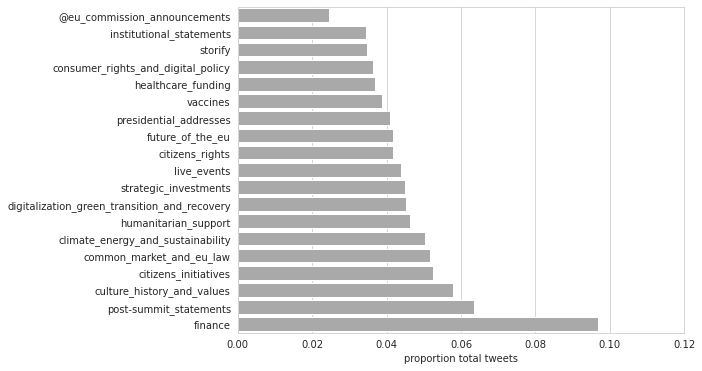

In [252]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=prop_topic[prop_topic['top_topic']!='infographics'].sort_values(by='text'), 
            y='top_topic', x='text', color='darkgrey')
plt.xlabel('proportion total tweets')
plt.ylabel('')
plt.xlim(0, 0.12)
plt.show()

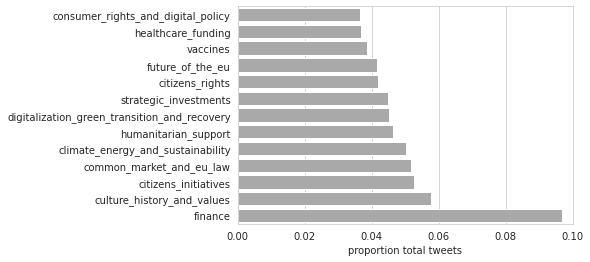

In [253]:
sns.barplot(data=prop_topic[prop_topic['is_events']!=1].sort_values(by='text'), 
            y='top_topic', x='text', color='darkgrey')
plt.xlabel('proportion total tweets')
plt.ylabel('')
plt.xlim(0, 0.1)
plt.show()

### Topic volume over time

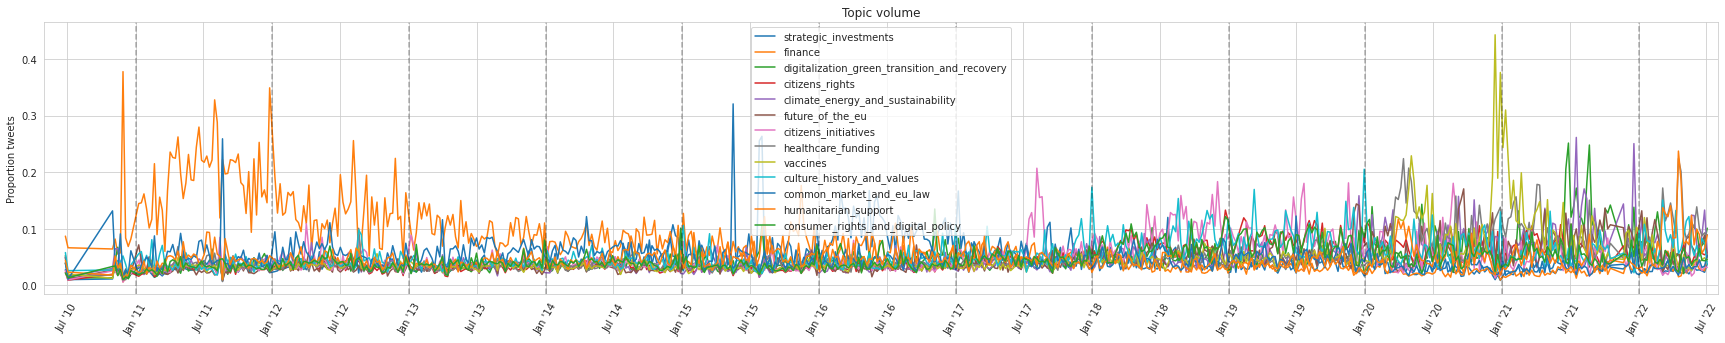

In [254]:
plot_topic_volume(set(topic_20comp) - set(exclude_20), 
                  freqs='W', 
                  roll_window=1,
                  metric='mean')
plt.show()

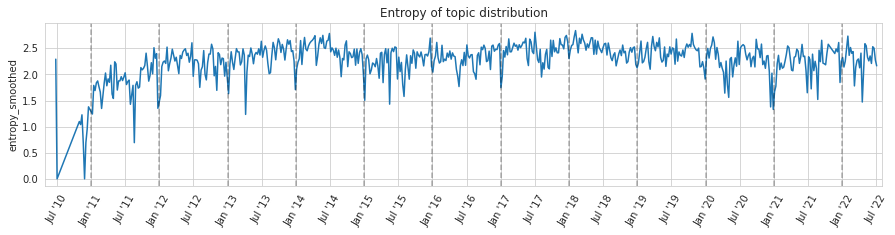

In [255]:
low_ent = plot_topic_volume([], 
                            metric='entropy',
                            freqs='W', 
                            roll_window=1)
plt.show()

In [256]:
#for l in low_ent:
#    print(l)
#    display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
#                      ((topic_20d['created_at'] - l).apply(lambda x: x.days) >= 0)].mean(axis=0)[topic_20comp].sort_values(ascending=False))
#    print('\n')

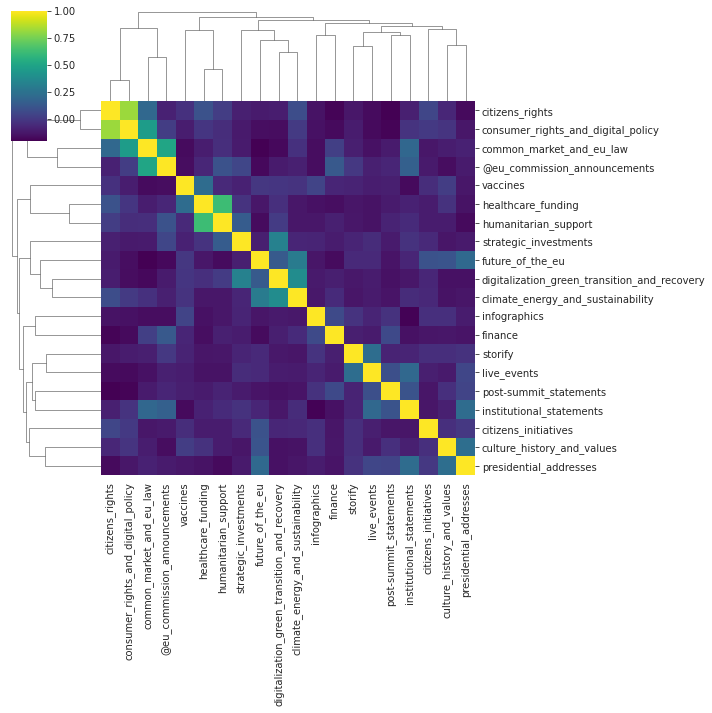

In [257]:
sns.clustermap(topic_20d[topic_20comp].corr(), cmap='viridis')

In [258]:
for l in low_ent:
    print(l)
    display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
                      ((topic_20d['created_at'] - l).apply(lambda x: x.days) >= 0)].groupby('top_topic').count()[['text']].sort_values(by='text', ascending=False))
    print('\n')

2013-04-07 00:00:00


,text
top_topic,
storify,18
finance,13
post-summit_statements,13
infographics,6
live_events,5
@eu_commission_announcements,2
digitalization_green_transition_and_recovery,2
presidential_addresses,2
climate_energy_and_sustainability,1




2020-12-27 00:00:00


,text
top_topic,
vaccines,10
climate_energy_and_sustainability,5
future_of_the_eu,5
common_market_and_eu_law,3
culture_history_and_values,3
digitalization_green_transition_and_recovery,2
citizens_rights,1
healthcare_funding,1




2020-12-13 00:00:00


,text
top_topic,
vaccines,12
citizens_rights,6
healthcare_funding,6
digitalization_green_transition_and_recovery,5
future_of_the_eu,3
infographics,3
climate_energy_and_sustainability,2
humanitarian_support,1
presidential_addresses,1




2015-05-17 00:00:00


,text
top_topic,
infographics,7
live_events,7
humanitarian_support,5
storify,4
institutional_statements,3
post-summit_statements,3
strategic_investments,3
finance,2
future_of_the_eu,2




2022-04-17 00:00:00


,text
top_topic,
healthcare_funding,8
humanitarian_support,6
consumer_rights_and_digital_policy,3
digitalization_green_transition_and_recovery,2
future_of_the_eu,2
infographics,2
presidential_addresses,2
citizens_initiatives,1
citizens_rights,1




2015-01-04 00:00:00


,text
top_topic,
infographics,4
institutional_statements,3
storify,3
citizens_initiatives,2
consumer_rights_and_digital_policy,2
live_events,2
common_market_and_eu_law,1
finance,1
humanitarian_support,1




2021-08-22 00:00:00


,text
top_topic,
culture_history_and_values,4
digitalization_green_transition_and_recovery,4
climate_energy_and_sustainability,3
healthcare_funding,3
infographics,3
citizens_initiatives,2
presidential_addresses,2
vaccines,2
consumer_rights_and_digital_policy,1




2020-05-03 00:00:00


,text
top_topic,
vaccines,24
culture_history_and_values,13
healthcare_funding,10
infographics,4
storify,4
consumer_rights_and_digital_policy,3
climate_energy_and_sustainability,3
citizens_rights,2
live_events,2




2015-08-02 00:00:00


,text
top_topic,
humanitarian_support,6
infographics,4
common_market_and_eu_law,2
digitalization_green_transition_and_recovery,2
post-summit_statements,2
strategic_investments,2
@eu_commission_announcements,1
climate_energy_and_sustainability,1
finance,1




2012-01-08 00:00:00


,text
top_topic,
finance,8
infographics,5
post-summit_statements,5
live_events,4
climate_energy_and_sustainability,3
culture_history_and_values,2
digitalization_green_transition_and_recovery,2
citizens_initiatives,1
citizens_rights,1


Low-entropy weeks are associated to crisis moments (mainly COVID, Ukrainian crisis)

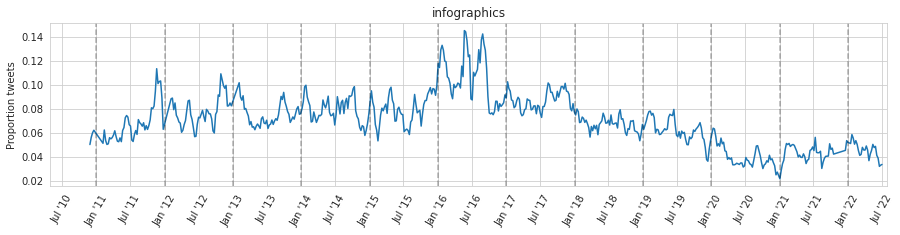

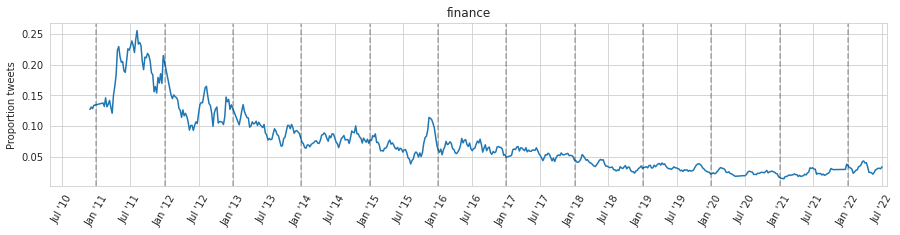

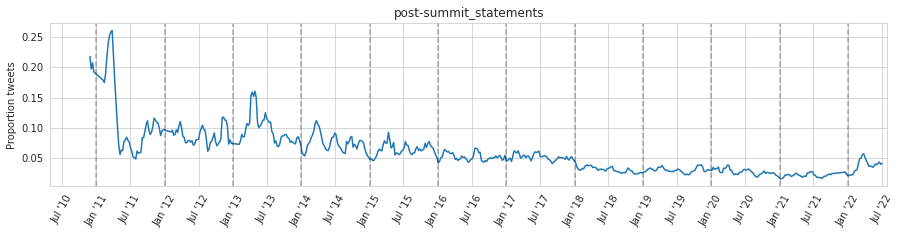

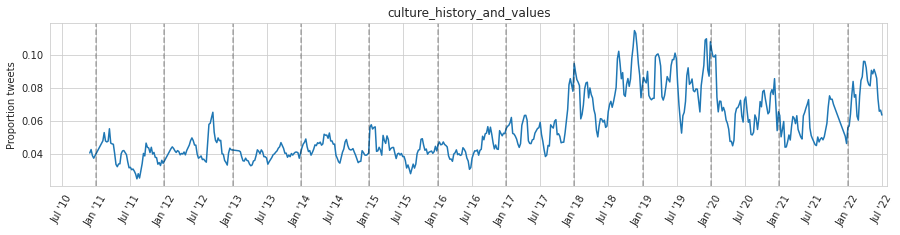

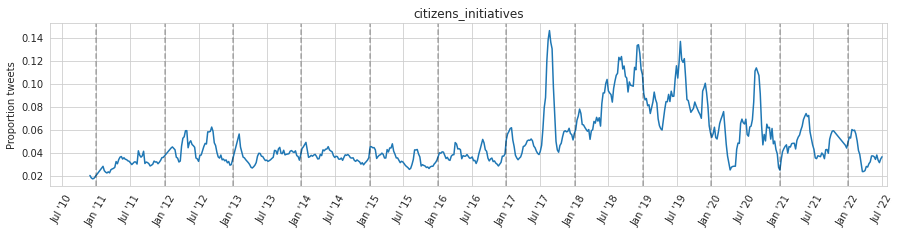

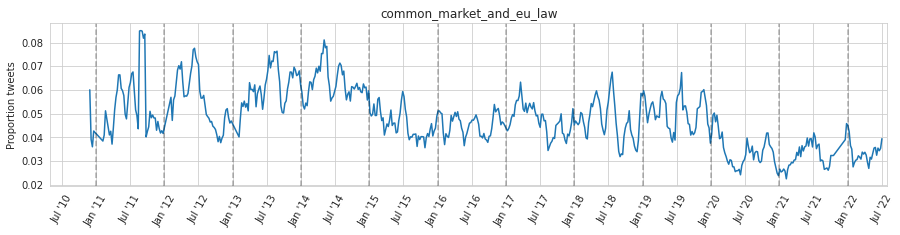

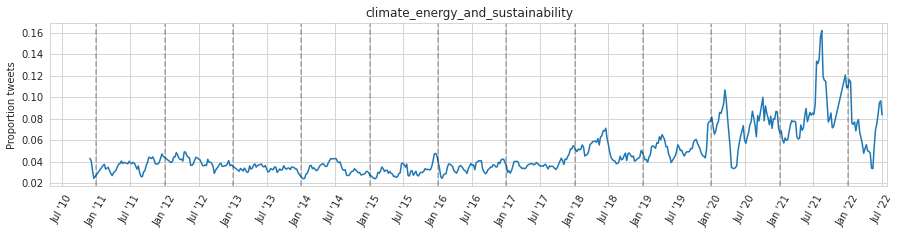

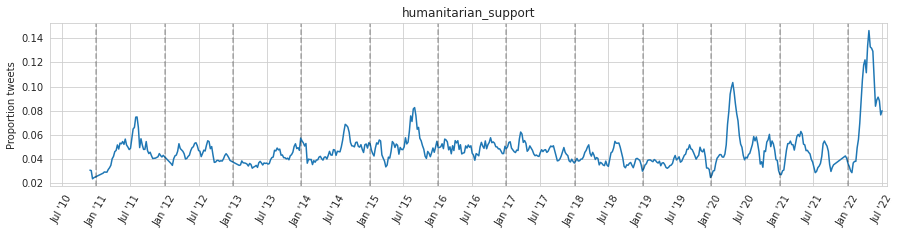

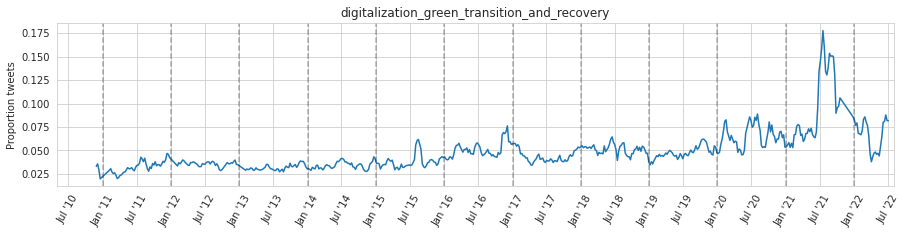

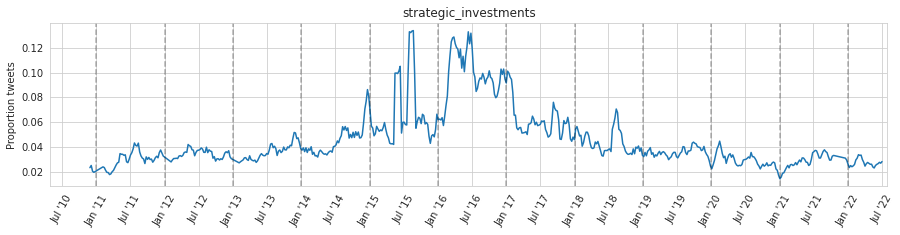

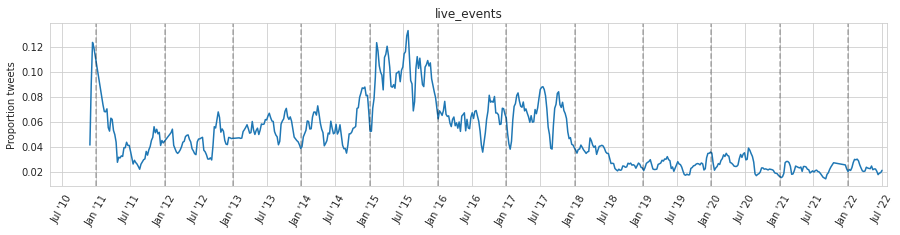

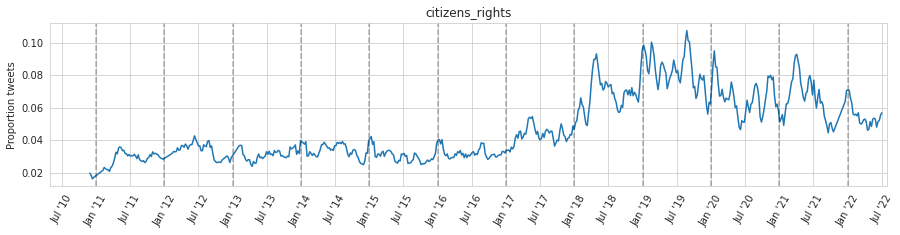

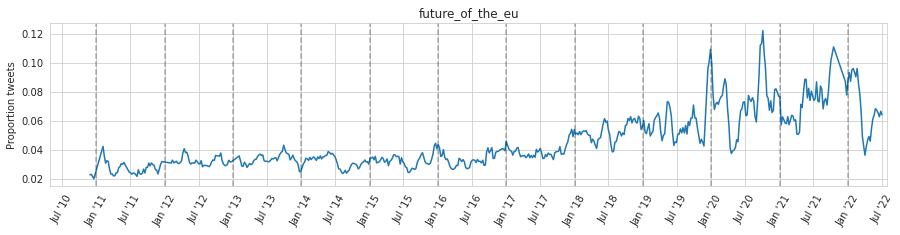

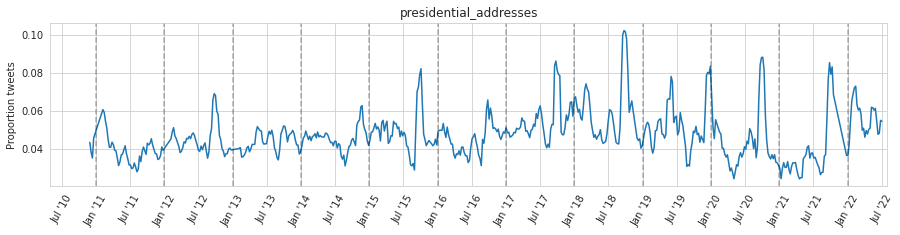

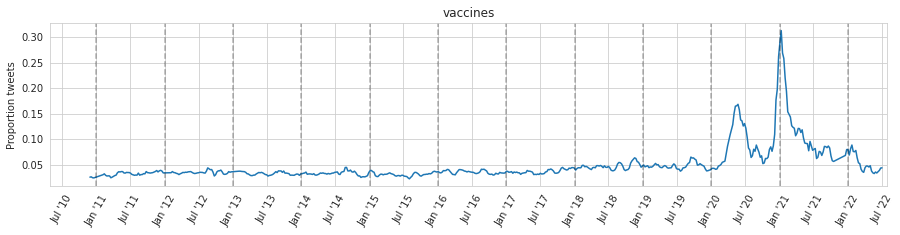

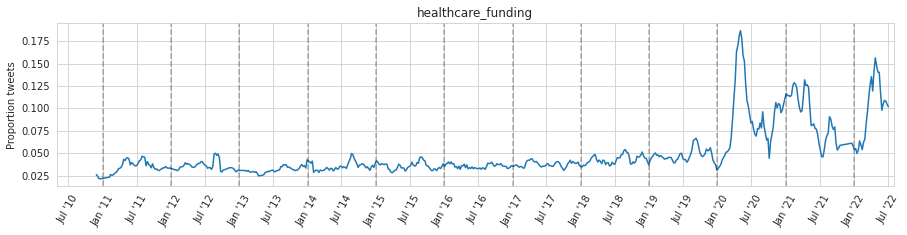

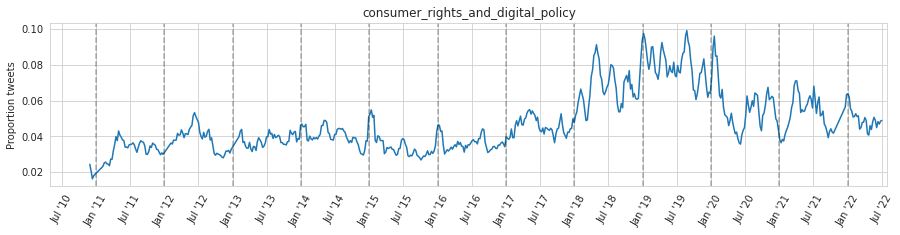

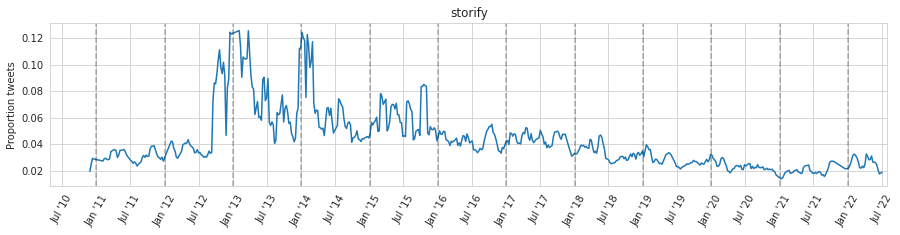

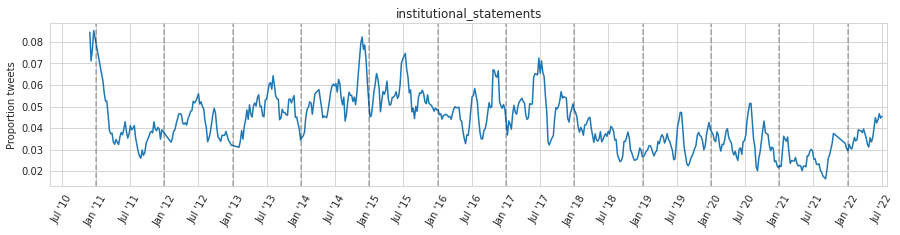

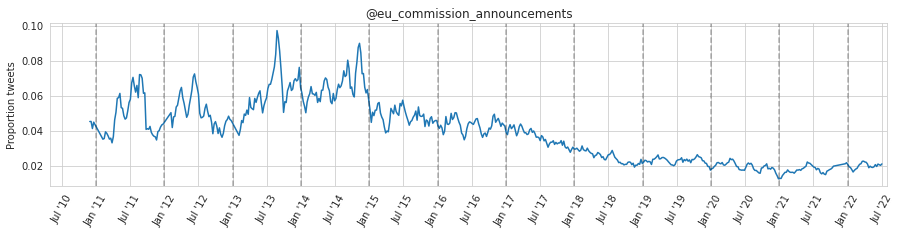

In [259]:
for t in prop_topic.sort_values(by='text', ascending=False).top_topic.tolist():
    plot_topic_volume([t], 
                      freqs='W', 
                      roll_window=5, metric='mean')
    plt.show()

### Engagement as a function of topic

In [260]:
aggs = topic_20d.groupby('top_topic')[['like_count', 
                                       'retweet_count', 
                                       'reply_count', 
                                       'quote_count']].agg('mean').reset_index()
aggs.columns = ['variable', 'mean_like', 'mean_rt', 'mean_reply', 'mean_quote']
top_likes = aggs.sort_values(by='mean_like').variable.tolist()
top_rts = aggs.sort_values(by='mean_rt').variable.tolist()
top_reply = aggs.sort_values(by='mean_reply').variable.tolist()
top_quote = aggs.sort_values(by='mean_quote').variable.tolist()

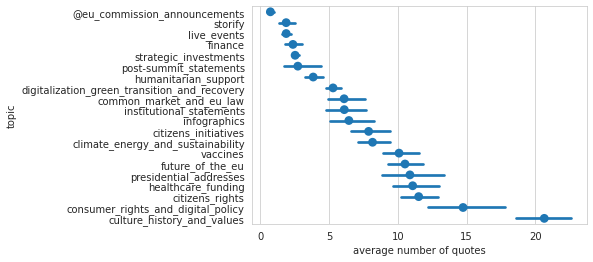

In [261]:
sns.pointplot(data=topic_20d,
               x='quote_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_quote)
plt.xlabel('average number of quotes')
plt.ylabel('topic')
plt.show()

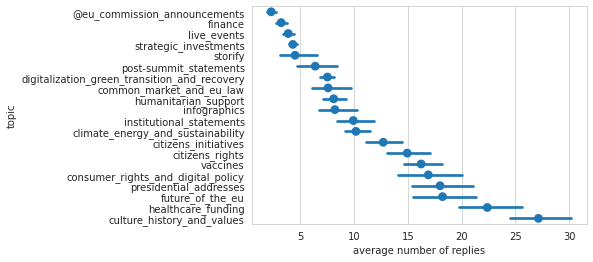

In [262]:
sns.pointplot(data=topic_20d,
               x='reply_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_reply,)
plt.xlabel('average number of replies')
plt.ylabel('topic')
plt.show()

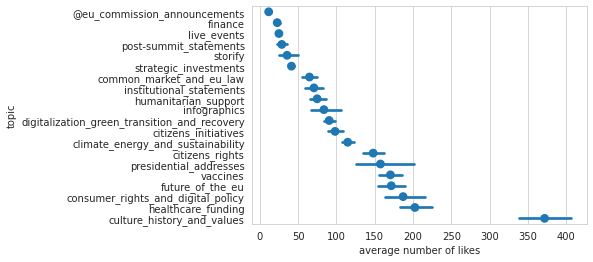

In [263]:
sns.pointplot(data=topic_20d, 
               x='like_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_likes)
plt.xlabel('average number of likes')
plt.ylabel('topic')
plt.show()

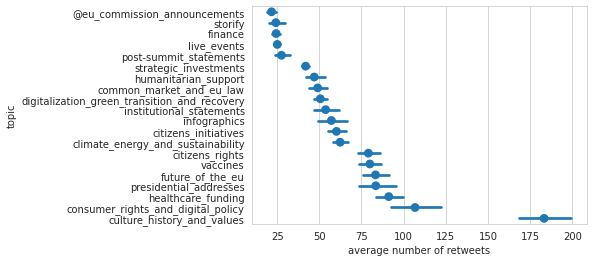

In [264]:
sns.pointplot(data=topic_20d, 
               x='retweet_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_rts)
plt.xlabel('average number of retweets')
plt.ylabel('topic')
plt.show()

### Topic-level coherence

In [265]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI
import nltk
from nltk.corpus import stopwords as stop_words
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [266]:
topic_df = pd.read_json('processed/pre_topic_tweets.jsonl', 
                        orient='records', 
                        lines=True)
train_idx = set(np.where(topic_df['topic_split']=='train')[0].tolist()) 
val_idx = set(np.where(topic_df['topic_split']=='val')[0].tolist())
test_idx = set(np.where(topic_df['topic_split']=='test')[0].tolist())
nltk.download('stopwords')
stopwords = list(stop_words.words("english"))
indices = topic_df['index'].tolist()
documents = topic_df.text.tolist()
sp = WhiteSpacePreprocessingStopwords(documents, 
                                      stopwords_list=stopwords, 
                                      vocabulary_size=500)
prepped, unprepped, vocab, retained_idx = sp.preprocess()
train_indices = [indices[r_idx] for r_idx in retained_idx
                 if r_idx in train_idx]
val_indices = [indices[r_idx] for r_idx in retained_idx
               if r_idx in val_idx]
test_indices = [indices[r_idx] for r_idx in retained_idx
                 if r_idx in test_idx]
prepped_train = [prepped[i] for i in range(len(prepped)) 
                 if retained_idx[i] in train_idx]
prepped_val = [prepped[i] for i in range(len(prepped)) 
               if retained_idx[i] in val_idx]
prepped_test = [prepped[i] for i in range(len(prepped)) 
                if retained_idx[i] in test_idx]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/roberta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/roberta/venvs/tw-langmod/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [267]:
coherences = []
for p in prepped_train, prepped_val, prepped_test:
    npmi = CoherenceNPMI(topics=[top_map[list(top_map.keys())[n_model]][str(i)] 
                               for i in range(20)], 
                         texts=[d.split() for d in p])
    coherences += npmi.score(topk=20, per_topic=True)

In [268]:
splits = ['train'] * 20 + ['val'] * 20 + ['test'] * 20 
names = topic_20comp * 3
coherence_df = pd.DataFrame(zip(coherences, names, splits), 
                            columns=['npmi', 'name', 'split'])


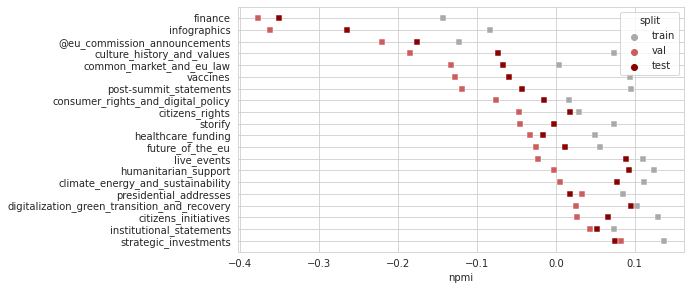

In [269]:
plt.subplots(figsize=(8,4.5))
sns.scatterplot(data=coherence_df.sort_values(by='npmi'),
                x='npmi', y='name', hue='split', 
                hue_order=['train','val','test'],
                marker='s', 
                palette=['darkgrey', 'indianred', 'darkred'])
plt.ylabel('')
plt.show()

### Comments analysis

Define useful functions for sentiment annotation

In [503]:
from transformers import pipeline
from torch.utils.data import Dataset

class TextData(Dataset):
    def __init__(self, dframe):
        self.dframe = dframe

    def __len__(self):
        return self.dframe.shape[0]

    def __getitem__(self, i):
        return self.dframe['response_text'].tolist()[i]

In [504]:
def _get_sentiment(dataset, model_path):
    pline = pipeline("text-classification", 
                     model=model_path, 
                     tokenizer=model_path, 
                     return_all_scores=True,
                     device=1)
    
    print('*** encoding ***')
    outs = pline(dataset, 
                 batch_size=64, 
                 function_to_apply='softmax')
    
    print('*** to dataframe ***')
    out_df = pd.DataFrame(outs)
    
    print('*** postprocessing ***')
    for c in out_df.columns:
        label = out_df[c][0]['label']
        out_df[c] = out_df[c].apply(lambda x: round(x['score'],4))
        out_df.rename({c: label}, axis=1, inplace=True)
    out_df['response_text'] = dataset.dframe['response_text'].tolist()
    out_df['created_at'] = dataset.dframe['created_at'].tolist()
    out_df['conversation_id'] = dataset.dframe['conversation_id'].tolist()
    
    return out_df

Do first bit of preprocessing (just get the responses, merge them with the IDs)

In [505]:
first_run_response = False

In [ ]:
id_df = _read_tweets(fs, fields=['text', 'id', 'lang'], metrics=[])
id_df = _preprocessing(id_df)

In [506]:
def _preprocess_response(df):
    df['response_text'] = df['response_text'].str.replace(r'http.*', '', regex=True)
    df = df[df['response_text'].str.len() > 0]
    df['response_lang_detected'] = df['response_text'].apply(language_detection)
    return df

In [507]:
if first_run_response:
    response_fs = glob.glob('data/EU_Commission_responses/*')
    response_df = _read_tweets(response_fs, 
                               metrics=[], 
                               fields=['text', 'lang', 'conversation_id'])
    response_df = response_df.rename({'text': 'response_text', 
                                      'lang': 'response_lang',
                                      'created_at': 'response_created_at'}, 
                                     axis=1)
    response_df = _preprocess_response(response_df)
    
    import random
    random.seed(42)
    train_size = int(response_df.shape[0] * .7)
    val_size = int(response_df.shape[0] * .1)
    test_size = response_df.shape[0] - train_size - val_size
    train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * test_size
    random.shuffle(train_test)
    response_df['topic_split'] = train_test 
    response_df.to_json('processed/all_responses.jsonl', 
                        orient='records', 
                        lines=True)
else:
    response_df = pd.read_json('processed/all_responses.jsonl', 
                               orient='records', 
                               lines=True)

Second chunk of preprocessing: strip noise from text, only keep languages for which we have models.

Also only keep length > 10, and annotate by sentiment and topic of the initial post.

In [508]:
postprocess_responses = True

In [509]:
if postprocess_responses:
    # Clean up text and only keep target languages
    response_df['response_text'] = response_df['response_text'].str.replace(r'@[A-Za-z0-9_]+', '', regex=True)
    response_df = response_df[response_df['response_lang_detected'].isin(['en', 'fr', 'it', 'de', 'es']) & 
                              (response_df['response_lang_detected'] == response_df['response_lang'])]
    response_df = response_df[response_df['response_text'].str.len() > 10]
    response_df['conversation_id'] = response_df.conversation_id.astype(str)
    id_df['id'] = id_df['id'].astype(str)
    # Get the ids
    response_df = response_df.merge(id_df, 
                                left_on='conversation_id', 
                                right_on='id', how='inner')
    response_df.rename({'topic_split': 'response_topic_split'}, axis=1, inplace=True)
    # Merge with topics
    response_df = response_df.merge(topic_20d, on=['text', 'created_at'])
    # Get sentiment
    dataset = TextData(response_df)
    sent_df = _get_sentiment(dataset, 'cardiffnlp/twitter-xlm-roberta-base-sentiment')
    response_df = response_df.merge(sent_df)
    # Save 
    response_df.to_json('processed/pre_topic_responses.jsonl', 
                        orient='records', 
                        lines=True)
else:
    response_df = pd.read_json('processed/pre_topic_responses.jsonl', 
                               orient='records', 
                               lines=True)   

<ipython-input-509-388ebd4e8cd8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_df['id'] = id_df['id'].astype(str)


*** encoding ***
*** to dataframe ***
*** postprocessing ***


In [513]:
response_df.groupby('response_lang').count()['response_text'].sort_values(ascending=False)

response_lang
en    66176
fr     1247
it     1111
es     1084
de      682
Name: response_text, dtype: int64

### Plot sentiment per topic

In [514]:
sent_columns = ['Negative', 'Neutral', 'Positive']
response_df['top_sentiment'] = response_df[sent_columns].apply(lambda x: sent_columns[x.argmax()], axis=1)
response_df['sent_confidence'] = response_df[sent_columns].apply(lambda x: x.max(), axis=1)

In [515]:
response_df['sent_entropy'] = response_df[sent_columns].apply(lambda x: entropy(x), axis=1)

In [516]:
grouped_top_emo = response_df[response_df['sent_confidence']>.6].groupby(['top_topic', 'top_sentiment']).count()['response_text'].reset_index()
counts = response_df.groupby('top_topic')['text'].count().reset_index()
grouped_top_emo = grouped_top_emo.merge(counts, on='top_topic')
grouped_top_emo['prop'] = grouped_top_emo['response_text'] / grouped_top_emo['text']

<ipython-input-522-db3f6b5f95ca>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data=grouped_top_emo.sort_values(by='prop')[(grouped_top_emo['top_sentiment']==sent) &


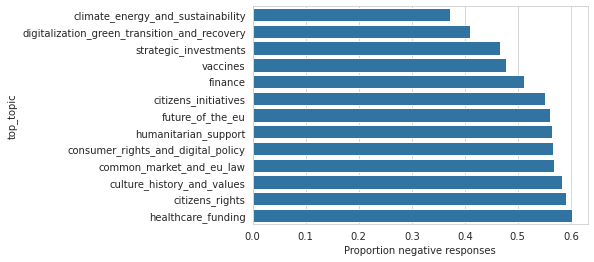

<ipython-input-522-db3f6b5f95ca>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data=grouped_top_emo.sort_values(by='prop')[(grouped_top_emo['top_sentiment']==sent) &


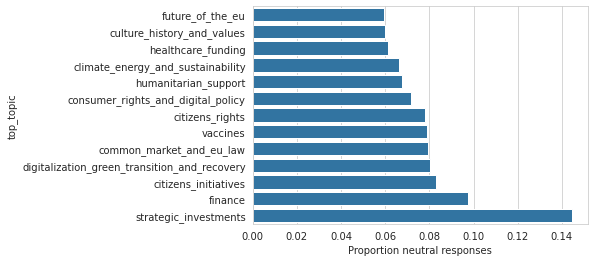

<ipython-input-522-db3f6b5f95ca>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.barplot(data=grouped_top_emo.sort_values(by='prop')[(grouped_top_emo['top_sentiment']==sent) &


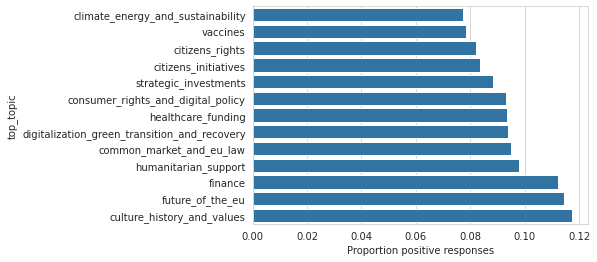

In [ ]:
for sent in sent_columns:
    sns.barplot(data=grouped_top_emo.sort_values(by='prop')[(grouped_top_emo['top_sentiment']==sent) & 
                                                            (~grouped_top_emo['top_topic'].isin(exclude_20))], 
                x='prop', 
                y='top_topic', 
                color=sns.color_palette()[0])
    plt.xlabel(f'Proportion {sent.lower()} responses')
    plt.show()

### Responses topic models

In [599]:
resp_topics = _load_and_process_performances('logs/responses/performances.jsonl')

<ipython-input-607-97fb5df33a9e>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = resp_topics.sort_values(by='test_npmi_10')[resp_topics['top_npmi']==1].unique_id.tolist()


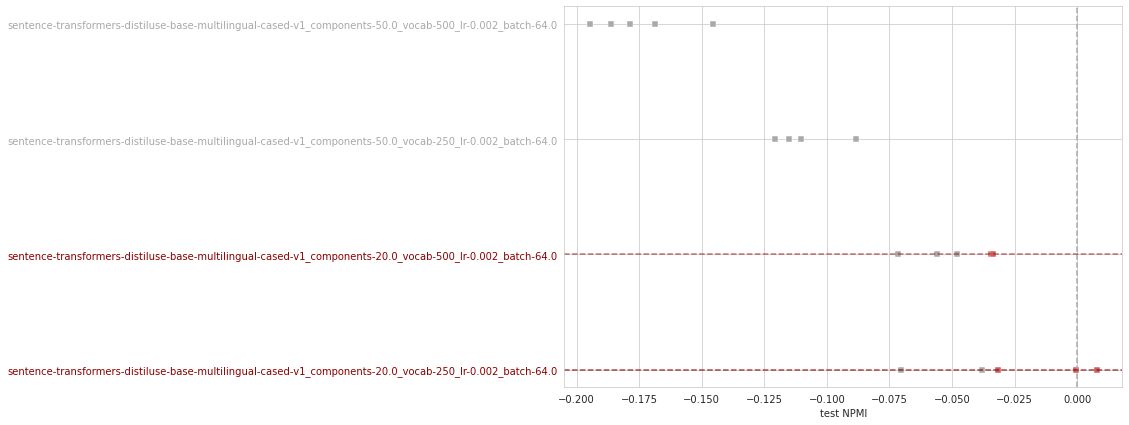

In [607]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,7))
plt.axvline(0, linestyle='--', color='darkgrey')
sns.scatterplot(data=resp_topics.sort_values(by='test_npmi_10'), 
                y='unique_id', x=f'test_npmi_10', 
                hue='top_npmi', 
                legend=False, 
                palette=['darkgrey', 'indianred'],
                marker='s')
best_names = resp_topics.sort_values(by='test_npmi_10')[resp_topics['top_npmi']==1].unique_id.tolist()
label_cols = []
for model_n in resp_topics.sort_values(by='test_npmi_10')["unique_id"].unique():
    if model_n in best_names:
        label_cols.append("darkred")
    else:
        label_cols.append("darkgrey")
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
plt.xlabel('test NPMI')
plt.ylabel('')
plt.show()

In [611]:
top_npmi = list(zip(resp_topics.sort_values(by='test_npmi_10', ascending=False).head(n=20).name.tolist(),
                    resp_topics.sort_values(by='test_npmi_10', ascending=False).head(n=20).run.tolist()))
top_map = {}
for t in top_npmi:
    if np.isnan(t[1]):
        topics = json.load(open(f'logs/responses/model_{t[0]}.json'))
        top_map[f'{t[0]}'] = topics
    else:
        topics = json.load(open(f'logs/responses/{t[0]}/topic_map_{int(t[1])}.json'))
        top_map[f'{t[0]}_{t[1]}'] = topics
n_model = 0

top_map_df = pd.DataFrame([top_map[list(top_map.keys())[n_model]][str(i)] 
                           for i in range(len(top_map[list(top_map.keys())[n_model]]))]).T
print(top_map_df)

         0            1           2          3         4        5       6   \
0      like    democracy          uk        usa      work     well  people   
1     would      catalan      brexit       nato  together     done  please   
2     money       rights         amp        amp    nurown     much    help   
3       get    catalonia        deal      china     lives    years    want   
4       tax     citizens       trade     russia    cannot    going      us   
5      give        spain         law    ukraine     money  already    stop   
6      back        state         get         us   prevent  without    need   
7    member      freedom        free       must      need      use    make   
8    states         vote  government      world      save     know    give   
9      euro      spanish        live      peace  approval    never  really   
10       uk    political      speech       help    global     euro     let   
11     know        human        open      close    europe   bett

### Next steps
- Inspect model and model of responses
- Predict on new data
- Make topics plots into plotly
- Wrap-up